In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
from brian2 import *
from brian2tools import *
from utils.equations import *
from utils.eq_params import *
from utils.funcs import plot_ln_G_vs_voltages


prefs.codegen.target = "numpy"

In [86]:
def max_conductances(voltages, neuron_group, neuron_group_statemon, restore_name):
    """
    Returns a list of max conductance values for given neuron group and list of voltages

    :param voltages: list of voltages to iterate over
    :param neuron_group: NeuronGroup to set voltage for each iteration
    :param neuron_group_statemon: StateMonitor to record current values
    :return: list of max conductance values
    """
    max_g = []
    for v in voltages:
        restore(restore_name)
        neuron_group.v = v
        run(200 * ms)
        max_g.append(abs(neuron_group_statemon.INa18[0]).max() / v)
    return max_g


def plot_currents(voltages, m_model_neuron, m_model_statemon, restore_name):
    """
    Plots current values for given list of voltages
    
    :param voltages: list of voltages to iterate over
    :param m_model_neuron: NeuronGroup to set voltage for each iteration 
    :param m_model_statemon: StateMonitor to record current values
    """
    for v in voltages:
        restore(restore_name)
        m_model_neuron.v = v
        run(100 * ms)
        plot(m_model_statemon.t / ms, m_model_statemon.INa18[0] / nA)
    xlabel("Time (ms)")
    ylabel("Current (nA)")
    grid()


Equation check

## Construct $Z_{eff}$ to evaluate Nav1.8 equaions above

### Nav1.8 literature equations

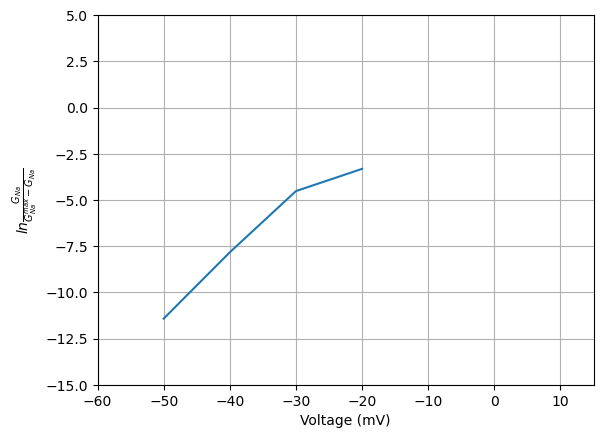

In [98]:
start_scope()
g18nav = 200*nS
patchclamp_gna18_eq = gNa18_eq + Equations("v : volt (constant)")

nav18_only_group = NeuronGroup(1, patchclamp_gna18_eq,
                               namespace={"gNa18": g18nav}, method="exponential_euler",
                               name="Nav18")
nav18_only_statemon = StateMonitor(nav18_only_group, ["INa18"], True)

store("patch_clamp_init")

experimental_voltages = arange(-50, -10, 10) * mV
nav18_max_gs = max_conductances(experimental_voltages, nav18_only_group, nav18_only_statemon, "patch_clamp_init")
plot_ln_G_vs_voltages(nav18_max_gs, experimental_voltages, g18nav)

## Krylov equations

### m3 model

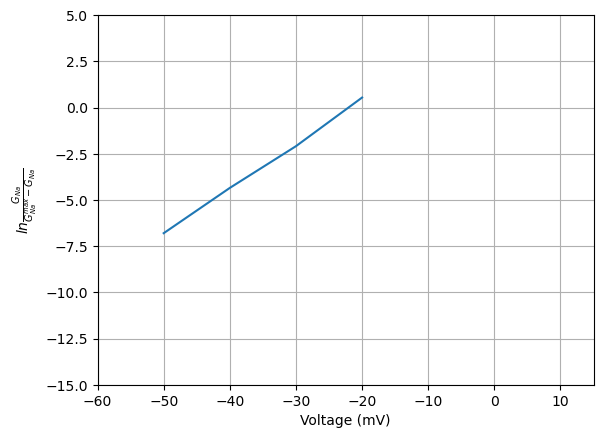

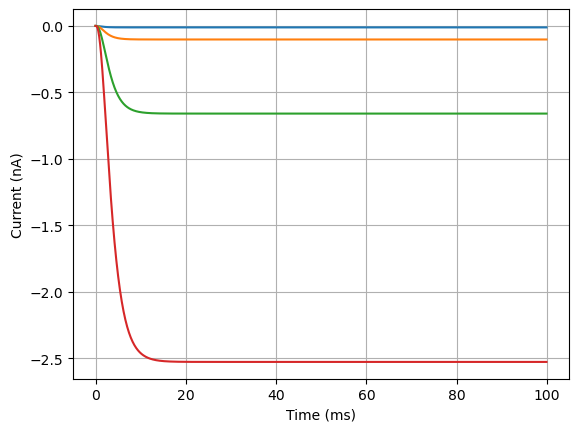

In [99]:
start_scope()
g18nav = 200 * nS
patchclamp_m3_model_eq = m3_model + Equations("v : volt (constant)")
m3_model_neuron = NeuronGroup(1, model=patchclamp_m3_model_eq, method="exponential_euler", namespace={"gNa18": g18nav})
m3_model_statemon = StateMonitor(m3_model_neuron, ["INa18"], record=True)
store("patch_clamp_m3_model")

m3_max_gs = max_conductances(experimental_voltages, m3_model_neuron, m3_model_statemon, "patch_clamp_m3_model")
plot_ln_G_vs_voltages(m3_max_gs, experimental_voltages, g18nav)

### m3 * h_s model

#### a - slow kinetics

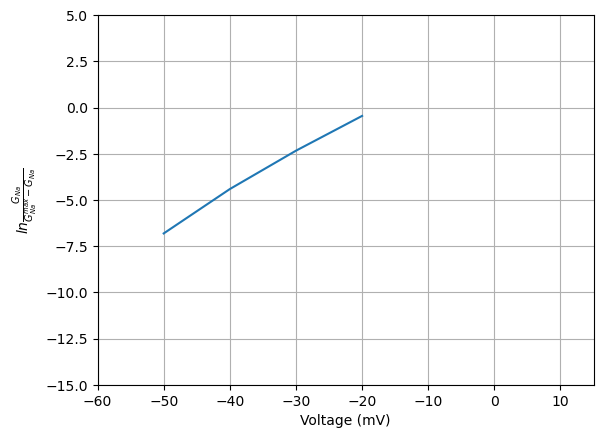

In [125]:
start_scope()
g18nav = 200 * nS
m3h_s_eq = m3h_s_model + Equations("v : volt (constant)")
m3h_s_model_neuron = NeuronGroup(1, model=m3h_s_eq, method="exponential_euler", namespace={"gNa18": g18nav})
m3h_s_model_statemon = StateMonitor(m3h_s_model_neuron, ["INa18", "m", "h"], record=True)

m3h_s_model_neuron.h = 1
store("m3h_s_model")

m3h_s_max_gs = max_conductances(experimental_voltages, m3h_s_model_neuron, m3h_s_model_statemon, "m3h_s_model")
plot_ln_G_vs_voltages(m3h_s_max_gs, experimental_voltages, g18nav)

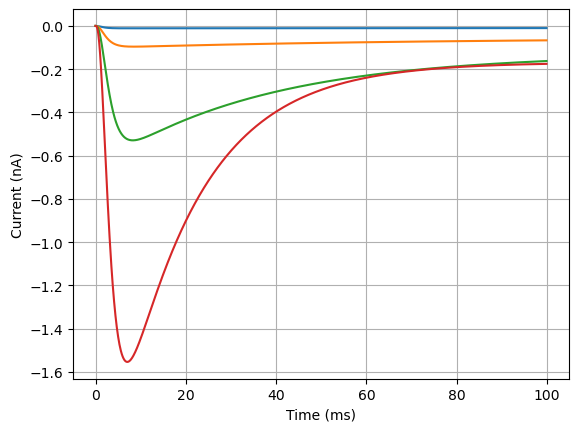

In [127]:
plot_currents(experimental_voltages, m3h_s_model_neuron, m3h_s_model_statemon, "m3h_s_model")

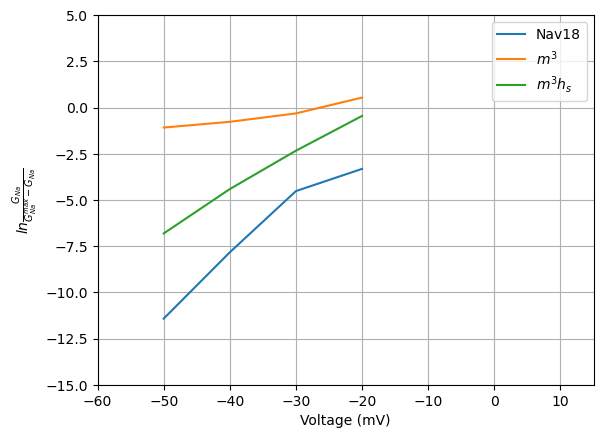

In [128]:
models_gs = [nav18_max_gs, m3_max_gs, m3h_s_max_gs]

for gs in models_gs:
    plot_ln_G_vs_voltages(gs, experimental_voltages, g18nav)
legend(["Nav18", "$m^3$", "$m^3h_s$"])